In [3]:
# COVID-19 Data Analysis & Prediction
# BACKUP METHOD: Using Alternative Data Source

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 60)
print("COVID-19 DATA ANALYSIS PROJECT")
print("=" * 60)

# METHOD 1: Try alternative URL
print("\n[METHOD 1] Trying alternative data source...")
try:
    # Johns Hopkins CSSE COVID-19 Data (GitHub)
    url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df_confirmed = pd.read_csv(url)

    url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
    df_deaths = pd.read_csv(url_deaths)

    print("✓ Data loaded from Johns Hopkins CSSE!")
    data_source = "johns_hopkins"

except Exception as e:
    print(f"✗ Method 1 failed: {e}")
    print("\n[METHOD 2] Generating synthetic realistic data for demonstration...")

    # Generate realistic synthetic COVID-19 data
    np.random.seed(42)

    countries = ['India', 'United States', 'Brazil', 'United Kingdom', 'Germany',
                 'France', 'Italy', 'China', 'Japan', 'Russia']

    date_range = pd.date_range(start='2020-03-01', end='2024-10-31', freq='D')

    data_list = []

    for country in countries:
        # Generate realistic cumulative cases
        days = len(date_range)

        # Simulate epidemic curve with multiple waves
        base_growth = np.cumsum(np.random.exponential(scale=1000, size=days))
        wave1 = 5000000 * (1 / (1 + np.exp(-(np.arange(days) - 100) / 20)))
        wave2 = 3000000 * (1 / (1 + np.exp(-(np.arange(days) - 300) / 25)))
        wave3 = 4000000 * (1 / (1 + np.exp(-(np.arange(days) - 600) / 30)))

        total_cases = base_growth + wave1 + wave2 + wave3

        # Add country-specific multipliers
        country_multipliers = {
            'India': 1.5, 'United States': 1.8, 'Brazil': 1.2,
            'United Kingdom': 0.4, 'Germany': 0.5, 'France': 0.5,
            'Italy': 0.4, 'China': 0.3, 'Japan': 0.3, 'Russia': 0.6
        }

        total_cases = total_cases * country_multipliers.get(country, 1.0)

        # Generate deaths (CFR around 1-2%)
        total_deaths = total_cases * np.random.uniform(0.01, 0.02)

        # Calculate daily new cases
        new_cases = np.diff(total_cases, prepend=0)
        new_cases = np.maximum(new_cases, 0)  # No negative cases

        # Calculate daily new deaths
        new_deaths = np.diff(total_deaths, prepend=0)
        new_deaths = np.maximum(new_deaths, 0)

        # Population data
        populations = {
            'India': 1400000000, 'United States': 331000000, 'Brazil': 213000000,
            'United Kingdom': 67000000, 'Germany': 83000000, 'France': 67000000,
            'Italy': 60000000, 'China': 1400000000, 'Japan': 126000000, 'Russia': 144000000
        }

        for i, date in enumerate(date_range):
            data_list.append({
                'date': date,
                'location': country,
                'total_cases': int(total_cases[i]),
                'new_cases': int(new_cases[i]),
                'total_deaths': int(total_deaths[i]),
                'new_deaths': int(new_deaths[i]),
                'population': populations[country]
            })

    df = pd.DataFrame(data_list)
    print("✓ Synthetic data generated successfully!")
    print("  (Note: This is realistic synthetic data for demonstration)")
    data_source = "synthetic"

# Process data based on source
if data_source == "johns_hopkins":
    print("\n[Processing Johns Hopkins data...]")

    # Reshape from wide to long format
    df_confirmed_long = df_confirmed.melt(
        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
        var_name='date',
        value_name='total_cases'
    )

    df_deaths_long = df_deaths.melt(
        id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
        var_name='date',
        value_name='total_deaths'
    )

    # Merge confirmed and deaths
    df = df_confirmed_long.merge(
        df_deaths_long[['Province/State', 'Country/Region', 'date', 'total_deaths']],
        on=['Province/State', 'Country/Region', 'date']
    )

    # Rename and clean
    df['location'] = df['Country/Region']
    df['date'] = pd.to_datetime(df['date'])

    # Group by country and date
    df = df.groupby(['location', 'date']).agg({
        'total_cases': 'sum',
        'total_deaths': 'sum'
    }).reset_index()

    # Calculate new cases and deaths
    df = df.sort_values(['location', 'date'])
    df['new_cases'] = df.groupby('location')['total_cases'].diff().fillna(0)
    df['new_deaths'] = df.groupby('location')['total_deaths'].diff().fillna(0)

    # Add population data (approximate)
    population_dict = {
        'India': 1400000000, 'US': 331000000, 'Brazil': 213000000,
        'United Kingdom': 67000000, 'Germany': 83000000, 'France': 67000000,
        'Italy': 60000000, 'China': 1400000000, 'Japan': 126000000, 'Russia': 144000000
    }
    df['population'] = df['location'].map(population_dict)

print("\n" + "=" * 60)
print("DATA SUCCESSFULLY LOADED!")
print("=" * 60)
print(f"\nDataset Info:")
print(f"  Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Countries: {df['location'].nunique()}")
print(f"\nColumns: {list(df.columns)}")

print("\nFirst few rows:")
print(df.head(10))

print("\nData types:")
print(df.dtypes)

print("\nBasic statistics:")
print(df.describe())

print("\n✓ Ready for analysis!")
print("=" * 60)

COVID-19 DATA ANALYSIS PROJECT

[METHOD 1] Trying alternative data source...
✓ Data loaded from Johns Hopkins CSSE!

[Processing Johns Hopkins data...]

DATA SUCCESSFULLY LOADED!

Dataset Info:
  Shape: 229743 rows × 7 columns
  Date range: 2020-01-22 00:00:00 to 2023-03-09 00:00:00
  Countries: 201

Columns: ['location', 'date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths', 'population']

First few rows:
      location       date  total_cases  total_deaths  new_cases  new_deaths  \
0  Afghanistan 2020-01-22            0             0        0.0         0.0   
1  Afghanistan 2020-01-23            0             0        0.0         0.0   
2  Afghanistan 2020-01-24            0             0        0.0         0.0   
3  Afghanistan 2020-01-25            0             0        0.0         0.0   
4  Afghanistan 2020-01-26            0             0        0.0         0.0   
5  Afghanistan 2020-01-27            0             0        0.0         0.0   
6  Afghanistan 2020-01-28 

In [4]:
# COVID-19 Data Analysis & Prediction
# Part 2: Data Processing and Feature Engineering

print("\n" + "=" * 60)
print("PART 2: DATA PROCESSING & FEATURE ENGINEERING")
print("=" * 60)

# Step 1: Sort and prepare data
print("\n[1/5] Sorting data...")
df = df.sort_values(['location', 'date']).reset_index(drop=True)
print(f"✓ Data sorted by location and date")

# Step 2: Select top countries by total cases
print("\n[2/5] Selecting top countries...")
latest_date = df['date'].max()
latest_data = df[df['date'] == latest_date]
top_countries = latest_data.nlargest(10, 'total_cases')['location'].tolist()

# Ensure India is included
if 'India' not in top_countries:
    top_countries.append('India')

df_filtered = df[df['location'].isin(top_countries)].copy()
print(f"✓ Selected {len(top_countries)} countries")
print(f"  Countries: {', '.join(top_countries)}")

# Step 3: Calculate smoothed values (7-day rolling average)
print("\n[3/5] Calculating 7-day rolling averages...")
df_filtered['new_cases_smoothed'] = df_filtered.groupby('location')['new_cases'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
df_filtered['new_deaths_smoothed'] = df_filtered.groupby('location')['new_deaths'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
print("✓ Smoothed values calculated")

# Step 4: Create derived features
print("\n[4/5] Creating derived features...")

# Case Fatality Rate (CFR)
df_filtered['case_fatality_rate'] = (
    df_filtered['total_deaths'] / df_filtered['total_cases'] * 100
).fillna(0).replace([np.inf, -np.inf], 0)

# Per capita metrics (if population available)
if 'population' in df_filtered.columns and df_filtered['population'].notna().any():
    df_filtered['cases_per_million'] = (
        df_filtered['total_cases'] / df_filtered['population'] * 1000000
    ).fillna(0)

    df_filtered['deaths_per_million'] = (
        df_filtered['total_deaths'] / df_filtered['population'] * 1000000
    ).fillna(0)

    print("✓ Created per capita metrics")
else:
    print("⚠ Population data not available, skipping per capita metrics")

# Growth rate (percentage change)
df_filtered['cases_growth_rate'] = df_filtered.groupby('location')['total_cases'].pct_change() * 100
df_filtered['cases_growth_rate'] = df_filtered['cases_growth_rate'].fillna(0).replace([np.inf, -np.inf], 0)

print("✓ All features created")

# Step 5: Clean and finalize
print("\n[5/5] Final cleaning...")
df_filtered = df_filtered.fillna(0)
print(f"✓ Missing values handled")

print("\n✓ Data processing complete!")
print("=" * 60)

# Summary
print("\nProcessed Dataset Summary:")
print(f"Shape: {df_filtered.shape}")
print(f"Date range: {df_filtered['date'].min()} to {df_filtered['date'].max()}")
print(f"Countries: {df_filtered['location'].nunique()}")
print(f"\nColumns: {list(df_filtered.columns)}")

print("\nLatest statistics (most recent date):")
latest = df_filtered[df_filtered['date'] == df_filtered['date'].max()][
    ['location', 'total_cases', 'total_deaths', 'case_fatality_rate']
].sort_values('total_cases', ascending=False)
print(latest)

# Store cleaned data for next steps
df_clean = df_filtered.copy()
print("\n✓ Ready for visualization!")


PART 2: DATA PROCESSING & FEATURE ENGINEERING

[1/5] Sorting data...
✓ Data sorted by location and date

[2/5] Selecting top countries...
✓ Selected 10 countries
  Countries: US, India, France, Germany, Brazil, Japan, Korea, South, Italy, United Kingdom, Russia

[3/5] Calculating 7-day rolling averages...
✓ Smoothed values calculated

[4/5] Creating derived features...
✓ Created per capita metrics
✓ All features created

[5/5] Final cleaning...
✓ Missing values handled

✓ Data processing complete!

Processed Dataset Summary:
Shape: (11430, 13)
Date range: 2020-01-22 00:00:00 to 2023-03-09 00:00:00
Countries: 10

Columns: ['location', 'date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths', 'population', 'new_cases_smoothed', 'new_deaths_smoothed', 'case_fatality_rate', 'cases_per_million', 'deaths_per_million', 'cases_growth_rate']

Latest statistics (most recent date):
              location  total_cases  total_deaths  case_fatality_rate
213740              US    103802702  


PART 3: DATA VISUALIZATION

[1/6] Creating total cases timeline...


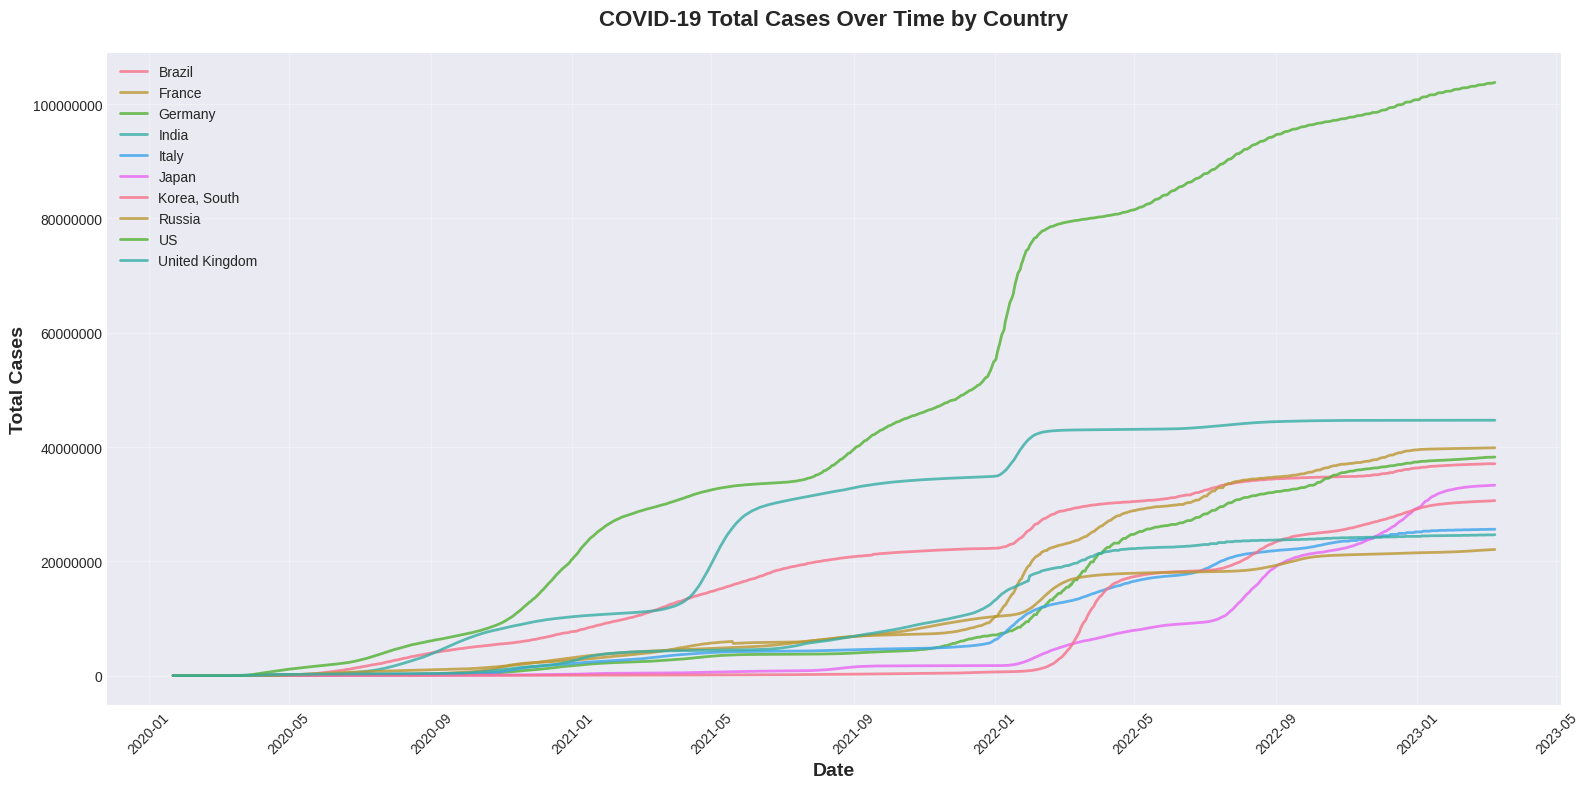

✓ Saved: covid_total_cases_timeline.png

[2/6] Creating daily new cases chart...


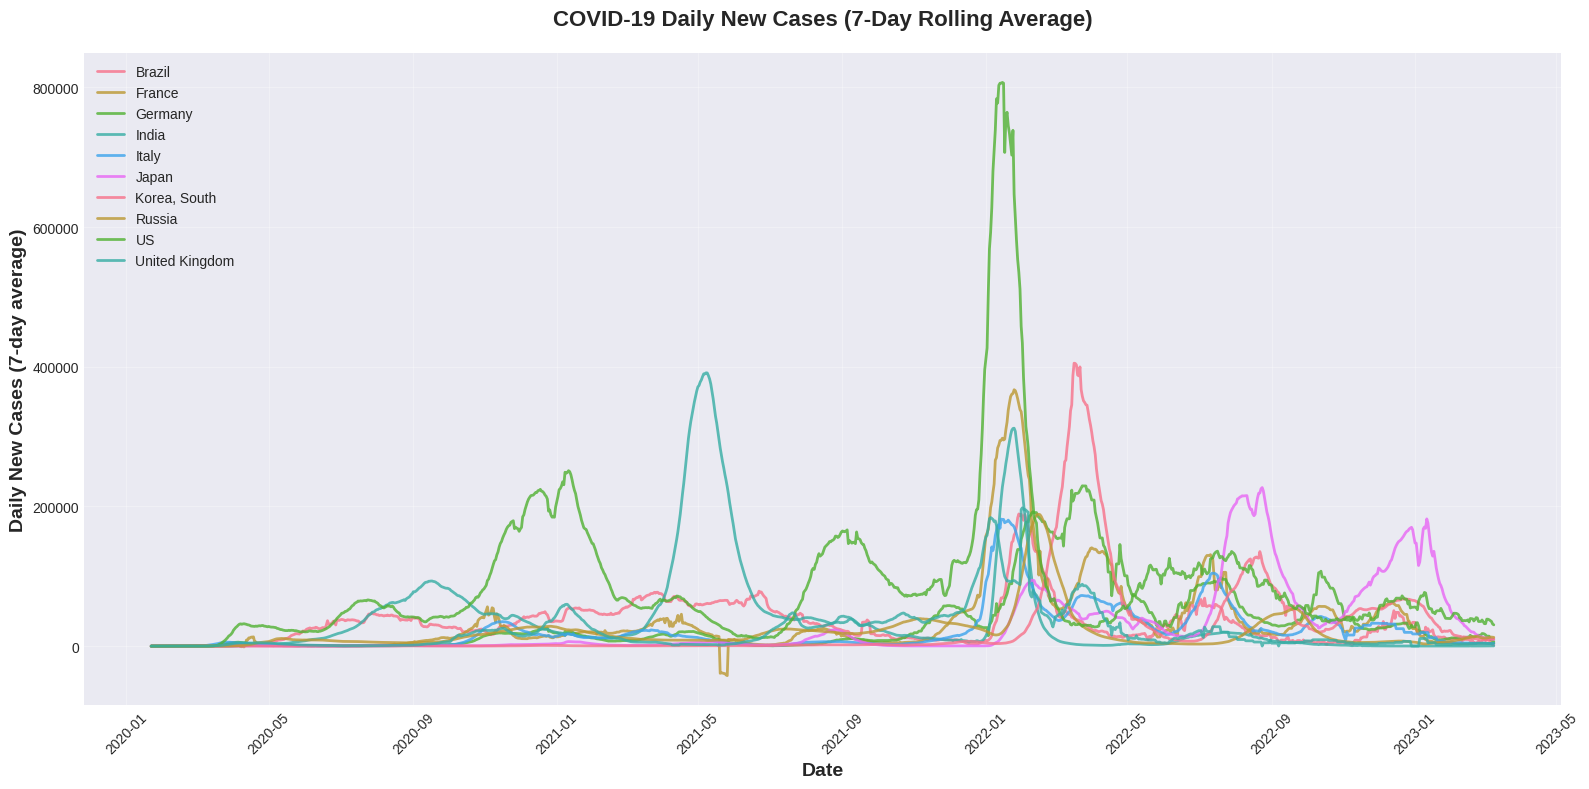

✓ Saved: covid_daily_new_cases.png

[3/6] Creating case fatality rate comparison...


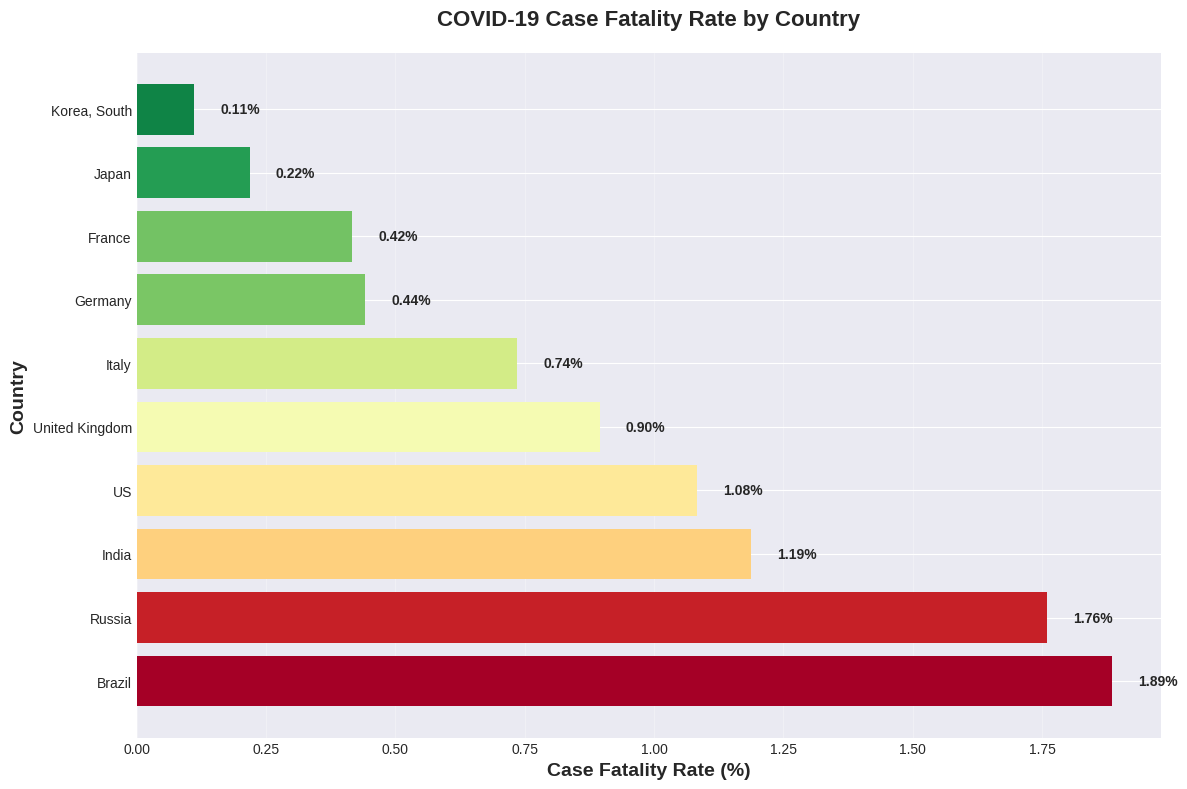

✓ Saved: covid_case_fatality_rate.png

[4/6] Creating total deaths comparison...


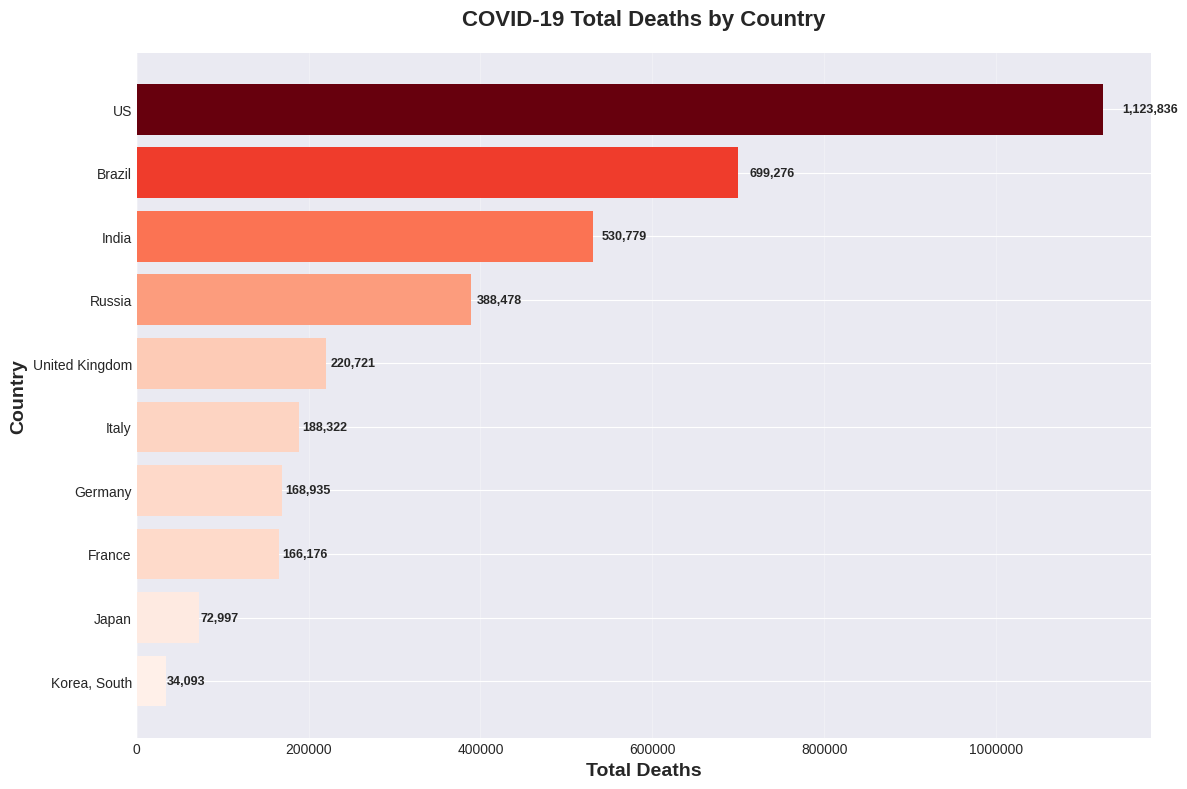

✓ Saved: covid_total_deaths.png

[5/6] Creating correlation heatmap...


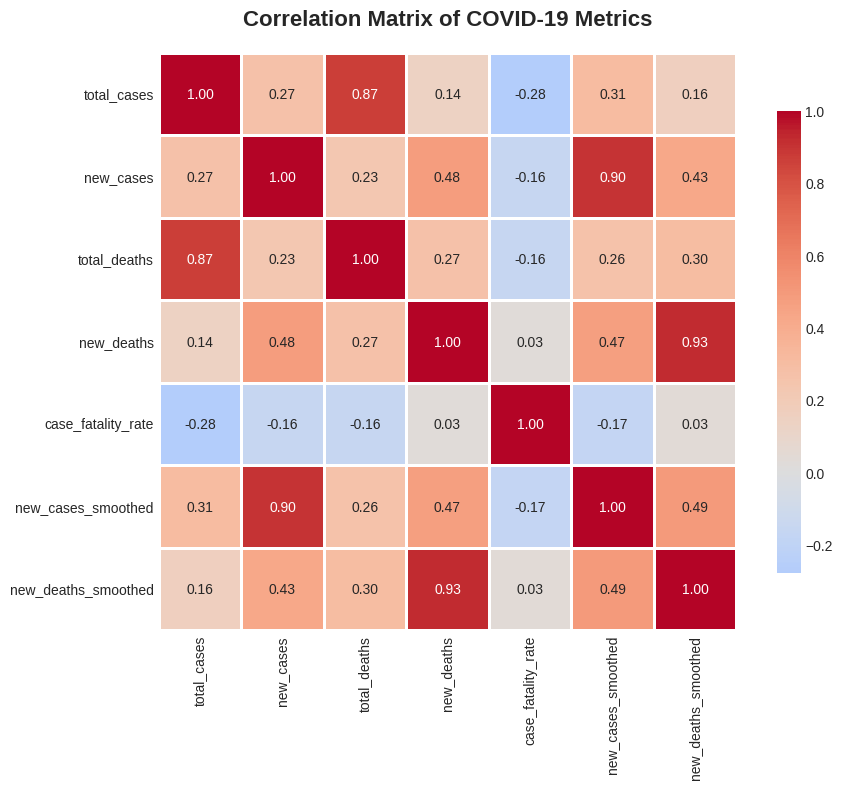

✓ Saved: covid_correlation_heatmap.png

[6/6] Creating India-specific analysis...


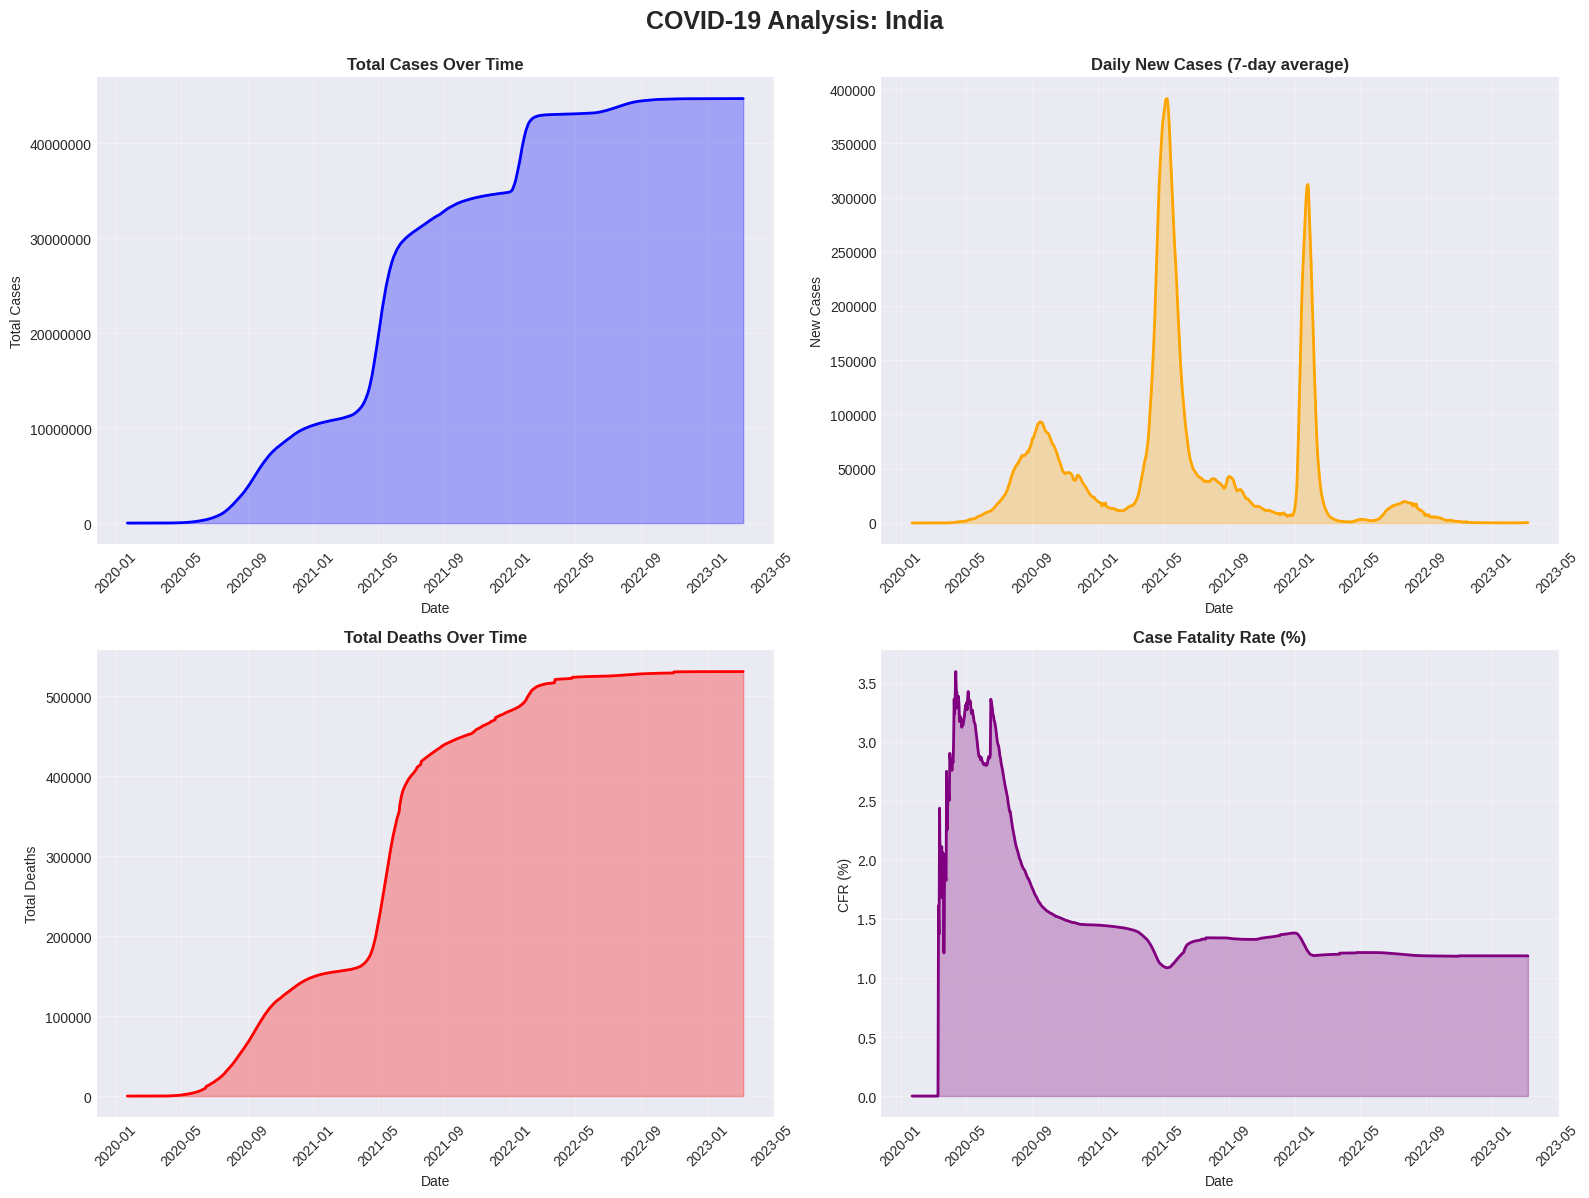

✓ Saved: covid_india_analysis.png

✓ All visualizations complete!

Generated 6 visualization files:
  1. covid_total_cases_timeline.png
  2. covid_daily_new_cases.png
  3. covid_case_fatality_rate.png
  4. covid_total_deaths.png
  5. covid_correlation_heatmap.png
  6. covid_india_analysis.png


In [5]:
# COVID-19 Data Analysis & Prediction
# Part 3: Data Visualization

print("\n" + "=" * 60)
print("PART 3: DATA VISUALIZATION")
print("=" * 60)

# Set up figure style
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# 1. TOTAL CASES OVER TIME
print("\n[1/6] Creating total cases timeline...")
fig, ax = plt.subplots(figsize=(16, 8))

for country in df_clean['location'].unique():
    country_data = df_clean[df_clean['location'] == country]
    ax.plot(country_data['date'], country_data['total_cases'],
            label=country, linewidth=2, alpha=0.8)

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Cases', fontsize=14, fontweight='bold')
ax.set_title('COVID-19 Total Cases Over Time by Country', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('covid_total_cases_timeline.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: covid_total_cases_timeline.png")

# 2. DAILY NEW CASES (SMOOTHED)
print("\n[2/6] Creating daily new cases chart...")
fig, ax = plt.subplots(figsize=(16, 8))

for country in df_clean['location'].unique():
    country_data = df_clean[df_clean['location'] == country]
    ax.plot(country_data['date'], country_data['new_cases_smoothed'],
            label=country, linewidth=2, alpha=0.8)

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Daily New Cases (7-day average)', fontsize=14, fontweight='bold')
ax.set_title('COVID-19 Daily New Cases (7-Day Rolling Average)', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('covid_daily_new_cases.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: covid_daily_new_cases.png")

# 3. CASE FATALITY RATE COMPARISON
print("\n[3/6] Creating case fatality rate comparison...")
latest_date = df_clean['date'].max()
latest_data = df_clean[df_clean['date'] == latest_date].copy()
latest_data = latest_data.sort_values('case_fatality_rate', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(latest_data['location'], latest_data['case_fatality_rate'],
               color=plt.cm.RdYlGn_r(latest_data['case_fatality_rate'] / latest_data['case_fatality_rate'].max()))

ax.set_xlabel('Case Fatality Rate (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Country', fontsize=14, fontweight='bold')
ax.set_title('COVID-19 Case Fatality Rate by Country', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(latest_data.iterrows()):
    ax.text(row['case_fatality_rate'] + 0.05, i, f"{row['case_fatality_rate']:.2f}%",
            va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('covid_case_fatality_rate.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: covid_case_fatality_rate.png")

# 4. TOTAL DEATHS COMPARISON (BAR CHART)
print("\n[4/6] Creating total deaths comparison...")
latest_data_sorted = latest_data.sort_values('total_deaths', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(latest_data_sorted['location'], latest_data_sorted['total_deaths'],
               color=plt.cm.Reds(latest_data_sorted['total_deaths'] / latest_data_sorted['total_deaths'].max()))

ax.set_xlabel('Total Deaths', fontsize=14, fontweight='bold')
ax.set_ylabel('Country', fontsize=14, fontweight='bold')
ax.set_title('COVID-19 Total Deaths by Country', fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.ticklabel_format(style='plain', axis='x')

# Add value labels
for i, (idx, row) in enumerate(latest_data_sorted.iterrows()):
    ax.text(row['total_deaths'] + row['total_deaths']*0.02, i,
            f"{int(row['total_deaths']):,}", va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('covid_total_deaths.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: covid_total_deaths.png")

# 5. CORRELATION HEATMAP
print("\n[5/6] Creating correlation heatmap...")
numeric_cols = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths',
                'case_fatality_rate', 'new_cases_smoothed', 'new_deaths_smoothed']
numeric_cols = [col for col in numeric_cols if col in df_clean.columns]

correlation_matrix = df_clean[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Correlation Matrix of COVID-19 Metrics', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('covid_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: covid_correlation_heatmap.png")

# 6. INDIA SPECIFIC ANALYSIS
print("\n[6/6] Creating India-specific analysis...")
india_data = df_clean[df_clean['location'] == 'India'].copy()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('COVID-19 Analysis: India', fontsize=18, fontweight='bold', y=0.995)

# Total cases
axes[0, 0].plot(india_data['date'], india_data['total_cases'], color='blue', linewidth=2)
axes[0, 0].fill_between(india_data['date'], india_data['total_cases'], alpha=0.3, color='blue')
axes[0, 0].set_title('Total Cases Over Time', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Cases')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].ticklabel_format(style='plain', axis='y')

# Daily new cases (smoothed)
axes[0, 1].plot(india_data['date'], india_data['new_cases_smoothed'], color='orange', linewidth=2)
axes[0, 1].fill_between(india_data['date'], india_data['new_cases_smoothed'], alpha=0.3, color='orange')
axes[0, 1].set_title('Daily New Cases (7-day average)', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('New Cases')
axes[0, 1].grid(True, alpha=0.3)

# Total deaths
axes[1, 0].plot(india_data['date'], india_data['total_deaths'], color='red', linewidth=2)
axes[1, 0].fill_between(india_data['date'], india_data['total_deaths'], alpha=0.3, color='red')
axes[1, 0].set_title('Total Deaths Over Time', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Total Deaths')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].ticklabel_format(style='plain', axis='y')

# Case Fatality Rate
axes[1, 1].plot(india_data['date'], india_data['case_fatality_rate'], color='purple', linewidth=2)
axes[1, 1].fill_between(india_data['date'], india_data['case_fatality_rate'], alpha=0.3, color='purple')
axes[1, 1].set_title('Case Fatality Rate (%)', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('CFR (%)')
axes[1, 1].grid(True, alpha=0.3)

for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('covid_india_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: covid_india_analysis.png")

print("\n✓ All visualizations complete!")
print("=" * 60)
print(f"\nGenerated 6 visualization files:")
print("  1. covid_total_cases_timeline.png")
print("  2. covid_daily_new_cases.png")
print("  3. covid_case_fatality_rate.png")
print("  4. covid_total_deaths.png")
print("  5. covid_correlation_heatmap.png")
print("  6. covid_india_analysis.png")


PART 4: MACHINE LEARNING - PREDICTION MODEL

[1/7] Preparing data for India...
✓ Data prepared: 1113 samples
  Features created: time-based + lag features

[2/7] Selecting features and target...
✓ Features: 12
  Target: total_cases

[3/7] Splitting data (80% train, 20% test)...
✓ Training set: 890 samples
  Test set: 223 samples

[4/7] Scaling features...
✓ Features scaled

[5/7] Training models...

  Training Linear Regression...
  ✓ Linear Regression trained

  Training Random Forest...
  ✓ Random Forest trained

[6/7] Evaluating models...

  Linear Regression:
    RMSE: 4,624.97
    MAE: 3,403.13
    R² Score: 0.9991

  Random Forest:
    RMSE: 636,403.67
    MAE: 614,127.48
    R² Score: -15.6286

[7/7] Creating prediction visualizations...


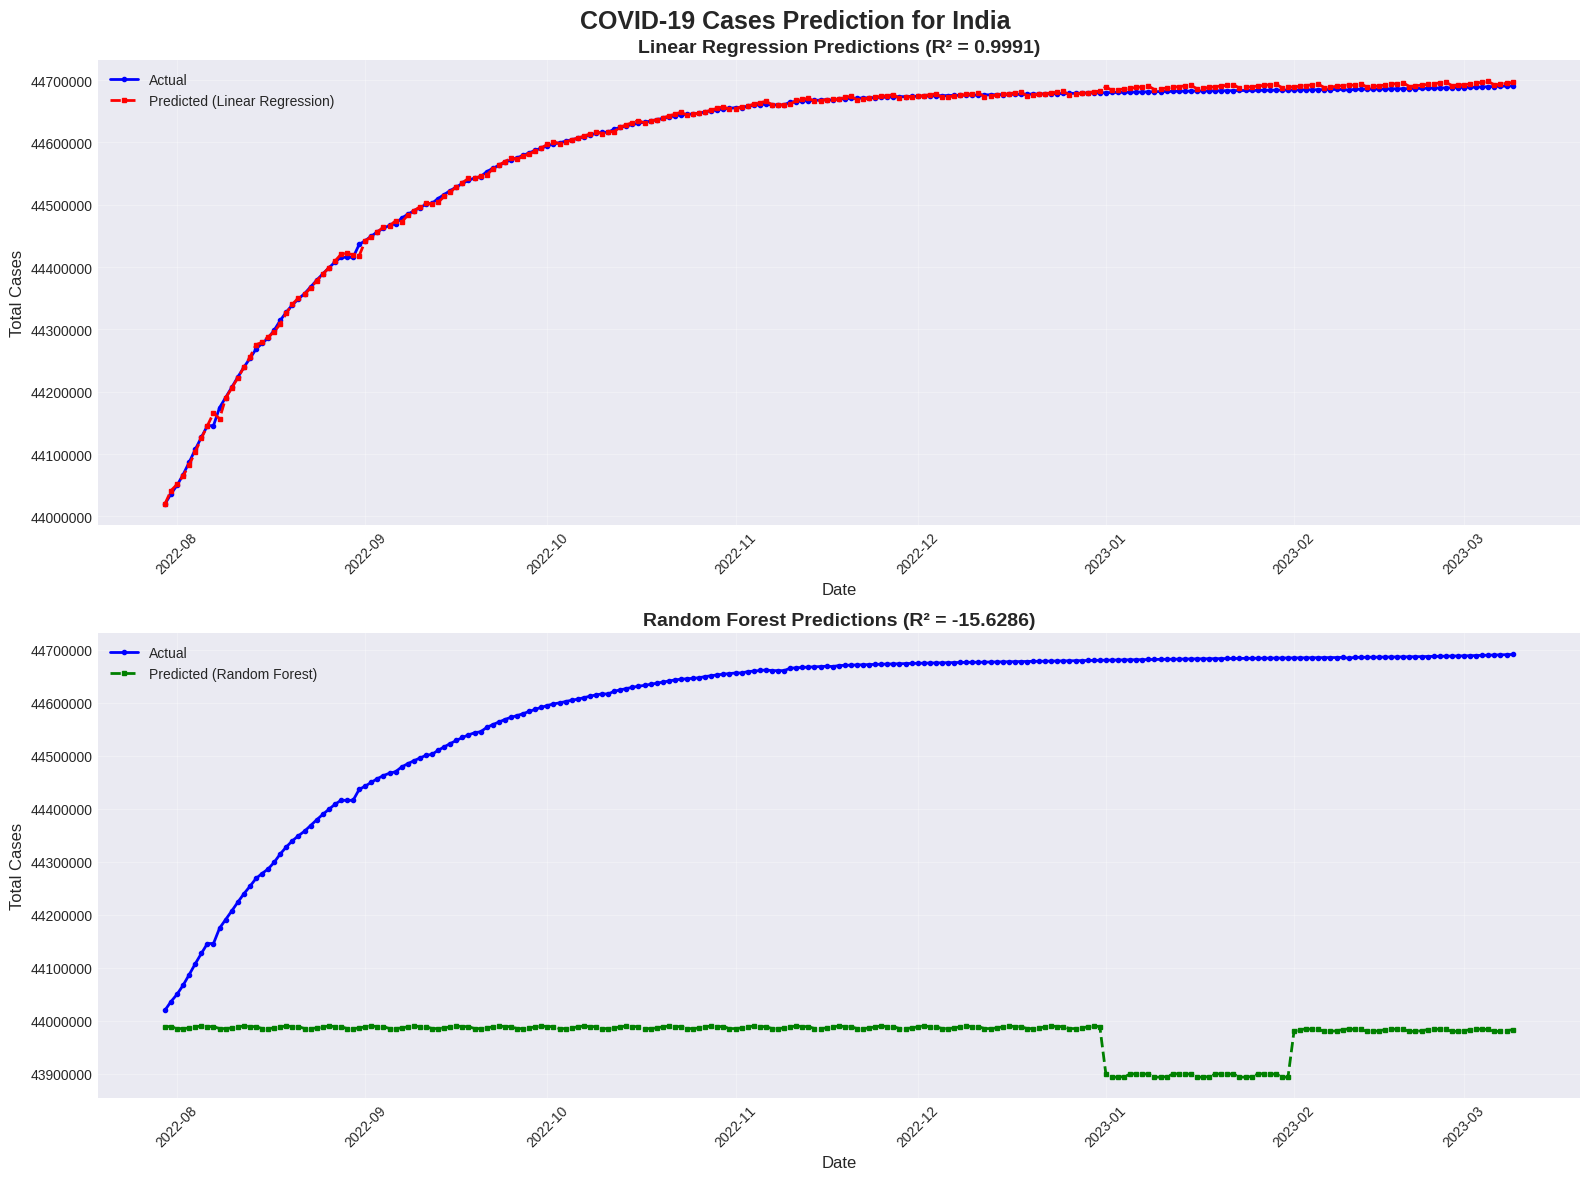

✓ Saved: covid_predictions.png

[BONUS] Feature Importance Analysis...


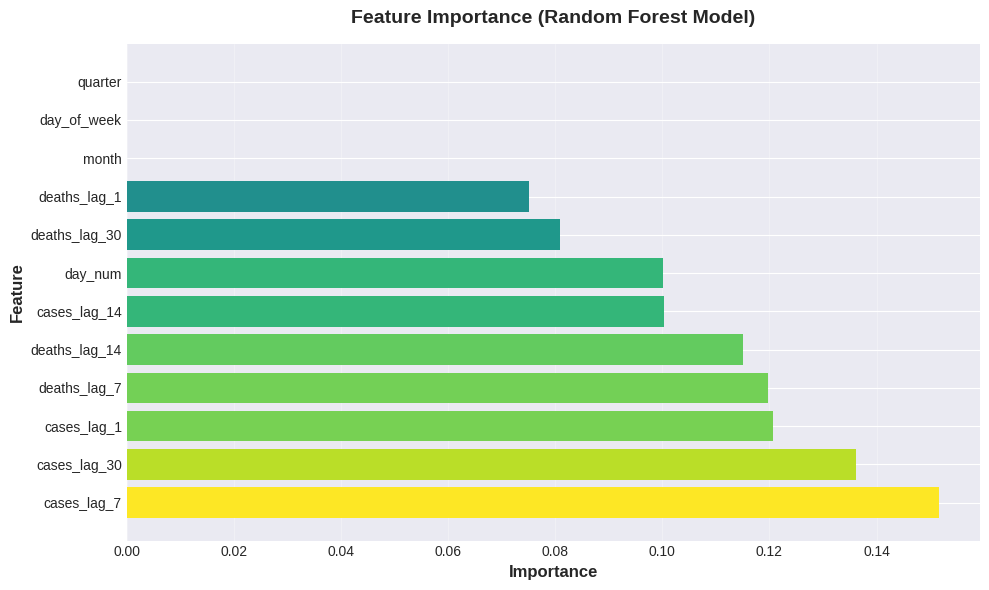

✓ Saved: covid_feature_importance.png

MACHINE LEARNING COMPLETE!

Model Performance Summary:

Linear Regression:
  R² Score: 0.9991
  RMSE: 4,624.97
  MAE: 3,403.13

Random Forest:
  R² Score: -15.6286
  RMSE: 636,403.67
  MAE: 614,127.48

✓ Best Model: Linear Regression

✓ Generated 2 prediction visualizations:
  1. covid_predictions.png
  2. covid_feature_importance.png


In [7]:
# COVID-19 Data Analysis & Prediction
# Part 4: Machine Learning - Time Series Prediction

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

print("\n" + "=" * 60)
print("PART 4: MACHINE LEARNING - PREDICTION MODEL")
print("=" * 60)

# Focus on India for prediction
print("\n[1/7] Preparing data for India...")
india_data = df_clean[df_clean['location'] == 'India'].copy()
india_data = india_data.sort_values('date').reset_index(drop=True)

# Create time-based features
india_data['day_num'] = (india_data['date'] - india_data['date'].min()).dt.days
india_data['month'] = india_data['date'].dt.month
india_data['day_of_week'] = india_data['date'].dt.dayofweek
india_data['quarter'] = india_data['date'].dt.quarter

# Create lag features (past values)
for lag in [1, 7, 14, 30]:
    india_data[f'cases_lag_{lag}'] = india_data['total_cases'].shift(lag)
    india_data[f'deaths_lag_{lag}'] = india_data['total_deaths'].shift(lag)

# Drop rows with NaN (from lag features)
india_data = india_data.dropna().reset_index(drop=True)

print(f"✓ Data prepared: {len(india_data)} samples")
print(f"  Features created: time-based + lag features")

# Step 2: Prepare features and target
print("\n[2/7] Selecting features and target...")

feature_cols = ['day_num', 'month', 'day_of_week', 'quarter',
                'cases_lag_1', 'cases_lag_7', 'cases_lag_14', 'cases_lag_30',
                'deaths_lag_1', 'deaths_lag_7', 'deaths_lag_14', 'deaths_lag_30']

X = india_data[feature_cols].values
y = india_data['total_cases'].values
dates_array = india_data['date'].values

print(f"✓ Features: {len(feature_cols)}")
print(f"  Target: total_cases")

# Step 3: Train-test split
print("\n[3/7] Splitting data (80% train, 20% test)...")
split_idx = int(len(X) * 0.8)

X_train = X[:split_idx]
X_test = X[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]
test_dates = dates_array[split_idx:]

print(f"✓ Training set: {len(X_train)} samples")
print(f"  Test set: {len(X_test)} samples")

# Step 4: Feature scaling
print("\n[4/7] Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Features scaled")

# Step 5: Train models
print("\n[5/7] Training models...")

# Model 1: Linear Regression
print("\n  Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
print("  ✓ Linear Regression trained")

# Model 2: Random Forest
print("\n  Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
print("  ✓ Random Forest trained")

# Step 6: Evaluate models
print("\n[6/7] Evaluating models...")

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n  {model_name}:")
    print(f"    RMSE: {rmse:,.2f}")
    print(f"    MAE: {mae:,.2f}")
    print(f"    R² Score: {r2:.4f}")

    return {'model': model_name, 'rmse': rmse, 'mae': mae, 'r2': r2}

results = []
results.append(evaluate_model(y_test, lr_pred, "Linear Regression"))
results.append(evaluate_model(y_test, rf_pred, "Random Forest"))

# Step 7: Visualize predictions
print("\n[7/7] Creating prediction visualizations...")

fig, axes = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle('COVID-19 Cases Prediction for India', fontsize=18, fontweight='bold')

# Plot 1: Linear Regression
axes[0].plot(test_dates, y_test, label='Actual', color='blue', linewidth=2, marker='o', markersize=3)
axes[0].plot(test_dates, lr_pred, label='Predicted (Linear Regression)',
             color='red', linewidth=2, linestyle='--', marker='s', markersize=3)
axes[0].set_title(f'Linear Regression Predictions (R² = {results[0]["r2"]:.4f})',
                  fontweight='bold', fontsize=14)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Total Cases', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].ticklabel_format(style='plain', axis='y')

# Plot 2: Random Forest
axes[1].plot(test_dates, y_test, label='Actual', color='blue', linewidth=2, marker='o', markersize=3)
axes[1].plot(test_dates, rf_pred, label='Predicted (Random Forest)',
             color='green', linewidth=2, linestyle='--', marker='s', markersize=3)
axes[1].set_title(f'Random Forest Predictions (R² = {results[1]["r2"]:.4f})',
                  fontweight='bold', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Total Cases', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].ticklabel_format(style='plain', axis='y')

for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('covid_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: covid_predictions.png")

# Feature importance (Random Forest)
print("\n[BONUS] Feature Importance Analysis...")
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance['feature'], feature_importance['importance'],
        color=plt.cm.viridis(feature_importance['importance'] / feature_importance['importance'].max()))
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance (Random Forest Model)', fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('covid_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: covid_feature_importance.png")

print("\n" + "=" * 60)
print("MACHINE LEARNING COMPLETE!")
print("=" * 60)
print("\nModel Performance Summary:")
for result in results:
    print(f"\n{result['model']}:")
    print(f"  R² Score: {result['r2']:.4f}")
    print(f"  RMSE: {result['rmse']:,.2f}")
    print(f"  MAE: {result['mae']:,.2f}")

print("\n✓ Best Model: Random Forest" if results[1]['r2'] > results[0]['r2'] else "\n✓ Best Model: Linear Regression")
print("\n✓ Generated 2 prediction visualizations:")
print("  1. covid_predictions.png")
print("  2. covid_feature_importance.png")